In [31]:
import numpy as np
import pandas as pd
from log_parser import parse_keyboard_log
from keyboard_heatmap import KeyboardHeatmap

# Segment length of each data sample
seg_length = 100

# List of parsed logfiles
keyboard = []
keyboard.append(parse_keyboard_log("./logs/JON/SPY/keyboard_actions.log"))
keyboard.append(parse_keyboard_log("./logs/MAR/SOL/keyboard_actions.log"))
keyboard.append(parse_keyboard_log("./logs/HEN/SOL/keyboard_actions.log"))
keyboard.append(parse_keyboard_log("./logs/ZIR/SOL/keyboard_actions.log"))

# Empty lists for inserting data
X_actual = []
Y_actual = []

for k in range(len(keyboard)):
    for i in range(int(keyboard[k].time.iloc[-1] / seg_length)):
        # For each segment in each logfile
        # Create a heatmap for that segment
        heatmap = KeyboardHeatmap(keyboard[k], i, seg_length)
        # If the heatmap isn't blank
        if heatmap.class_label() != 'Null':
            X_actual.append(heatmap.heatmap_data().ravel().tolist())
            Y_actual.append(heatmap.class_label())

'''
# Display features
for i in range(len(X_actual)):
    print(X_actual[i][:10], Y_actual[i])
'''
print(f"Data samples: {len(Y_actual)}")


Data samples: 145


In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Split into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_actual, Y_actual, random_state=0)

# Create random forests classifier object
# n_jobs controls multithreading, -1 uses all available threads
# criterion determines how well a feature splits data, we use gini
# max_features determines the number of candidate features available for a best split
# n_estimators determines the number of trees in our forest
# oob_score determines whether or not our forest uses out of bag error
rfc = RandomForestClassifier(n_jobs=-1, criterion='gini', max_features= 'sqrt', n_estimators = 100, oob_score = True) 

model = rfc.fit(X_train, Y_train)

# Print best score
print( 
    f"Train score: {rfc.score(X_train, Y_train)} " +
    f"Test score: {rfc.score(X_test, Y_test)}"
)

# Predict on test set
Y_predict = rfc.predict(X_test)

# Ouput predictions vs ground truth values
for i in range(len(Y_predict)):
    print(f"Actual: {Y_test[i]:<10}  -  Predicted: {Y_predict[i]}")

Train score: 1.0 Test score: 1.0
Actual: JONSPY      -  Predicted: JONSPY
Actual: JONSPY      -  Predicted: JONSPY
Actual: JONSPY      -  Predicted: JONSPY
Actual: MARSOL      -  Predicted: MARSOL
Actual: HENSOL      -  Predicted: HENSOL
Actual: HENSOL      -  Predicted: HENSOL
Actual: MARSOL      -  Predicted: MARSOL
Actual: JONSPY      -  Predicted: JONSPY
Actual: ZIRSOL      -  Predicted: ZIRSOL
Actual: JONSPY      -  Predicted: JONSPY
Actual: MARSOL      -  Predicted: MARSOL
Actual: MARSOL      -  Predicted: MARSOL
Actual: ZIRSOL      -  Predicted: ZIRSOL
Actual: MARSOL      -  Predicted: MARSOL
Actual: ZIRSOL      -  Predicted: ZIRSOL
Actual: MARSOL      -  Predicted: MARSOL
Actual: JONSPY      -  Predicted: JONSPY
Actual: ZIRSOL      -  Predicted: ZIRSOL
Actual: HENSOL      -  Predicted: HENSOL
Actual: JONSPY      -  Predicted: JONSPY
Actual: HENSOL      -  Predicted: HENSOL
Actual: ZIRSOL      -  Predicted: ZIRSOL
Actual: ZIRSOL      -  Predicted: ZIRSOL
Actual: HENSOL      -  P

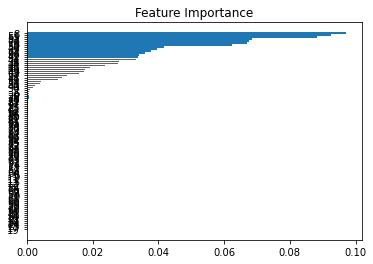

In [33]:
import matplotlib.pyplot as plt

# We want to plot the feature importance of all features to see how our classifier is splitting data
importances = model.feature_importances_
indices = np.argsort(importances)

# names = [magicFunctionThatGivesNames() for i in indices]

# Barplot
plt.barh(range(len(indices)), importances[indices])
# Add feature names as y-axis labels
# replace [indices[i] for i in indices] with feature labels
plt.yticks(range(len(indices)), [indices[i] for i in indices])
# Create plot title
plt.title("Feature Importance")
# Show plot
plt.show()

[Text(376.42857142857144, 570.4444444444445, 'X[78] <= 0.045\ngini = 0.744\nsamples = 74\nvalue = [32, 22, 24, 30]'),
 Text(332.1428571428571, 503.3333333333333, 'X[1] <= 0.4\ngini = 0.71\nsamples = 63\nvalue = [32, 8, 24, 30]'),
 Text(221.42857142857142, 436.22222222222223, 'X[58] <= 0.025\ngini = 0.652\nsamples = 48\nvalue = [32, 7, 7, 28]'),
 Text(177.14285714285714, 369.1111111111111, 'X[64] <= 0.141\ngini = 0.586\nsamples = 43\nvalue = [32, 7, 0, 28]'),
 Text(132.85714285714286, 302.0, 'X[11] <= 0.253\ngini = 0.541\nsamples = 35\nvalue = [32, 7, 0, 13]'),
 Text(88.57142857142857, 234.88888888888886, 'X[9] <= 0.426\ngini = 0.634\nsamples = 26\nvalue = [16, 7, 0, 13]'),
 Text(44.285714285714285, 167.77777777777777, 'gini = 0.0\nsamples = 5\nvalue = [0, 6, 0, 0]'),
 Text(132.85714285714286, 167.77777777777777, 'X[91] <= 0.419\ngini = 0.527\nsamples = 21\nvalue = [16, 1, 0, 13]'),
 Text(88.57142857142857, 100.66666666666663, 'X[4] <= 0.02\ngini = 0.133\nsamples = 11\nvalue = [0, 1, 0,

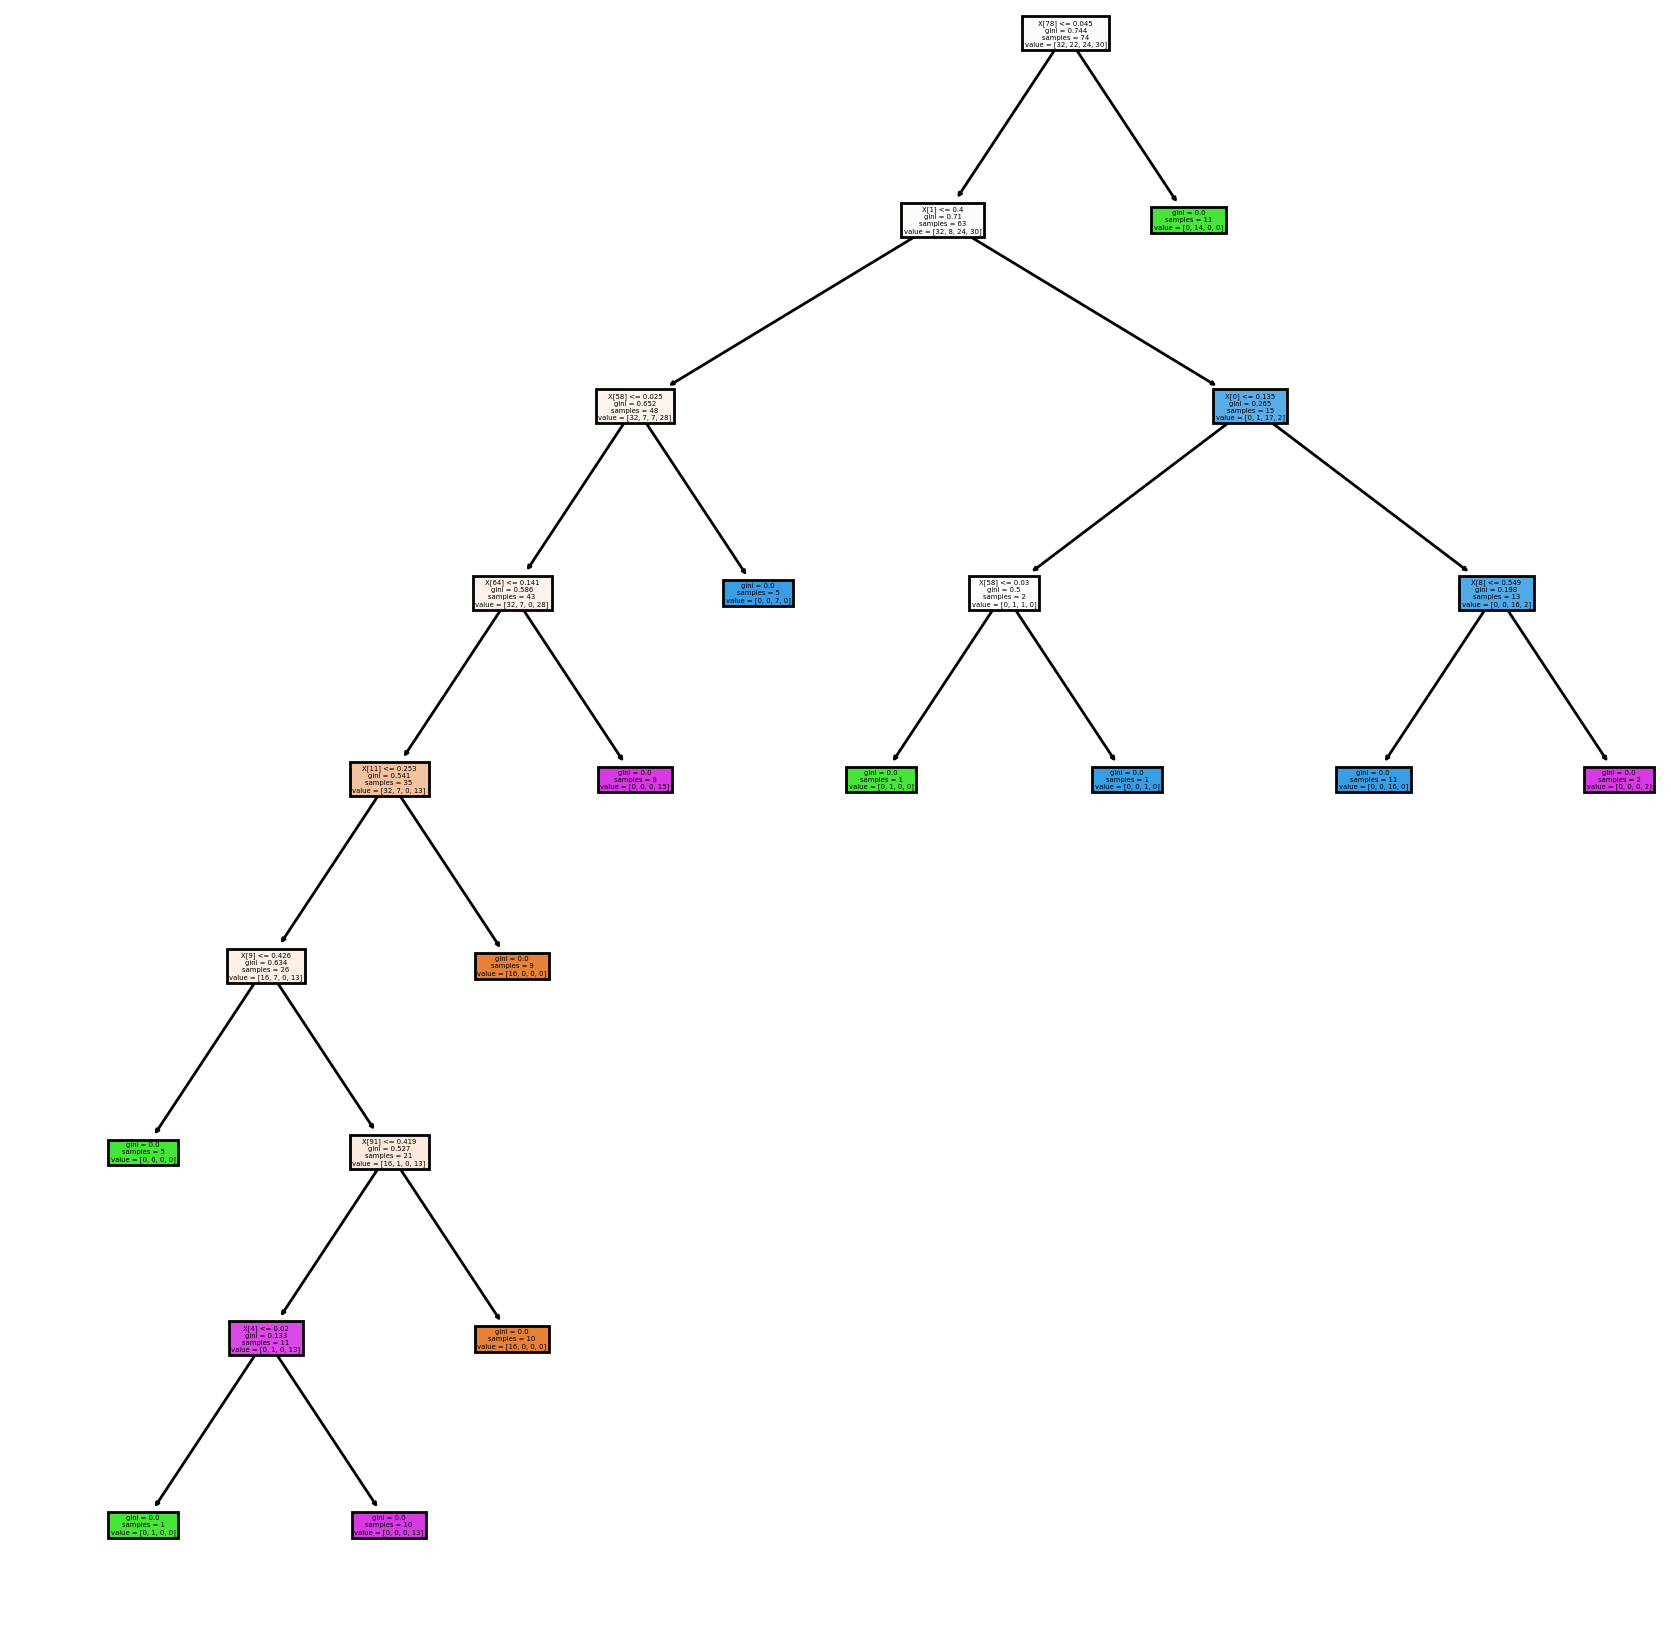

In [34]:
from sklearn import tree

# Plot one tree in our forest for fun
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=200)
tree.plot_tree(rfc.estimators_[0], filled = True)